#구글 드라이브 마운트하여 구글 드라이브 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#시각화

In [2]:
from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np

import matplotlib.font_manager as fm

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import matplotlib.pyplot as plt

In [5]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 폰트 설정
plt.rcParams["font.family"] = 'NanumBarunGothic'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [5]:
!pip install koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.3 MB/s eta 0:00:00


만약에 한글 오류가 나면 런타임 재시작하고 시각화하여야 합니다.

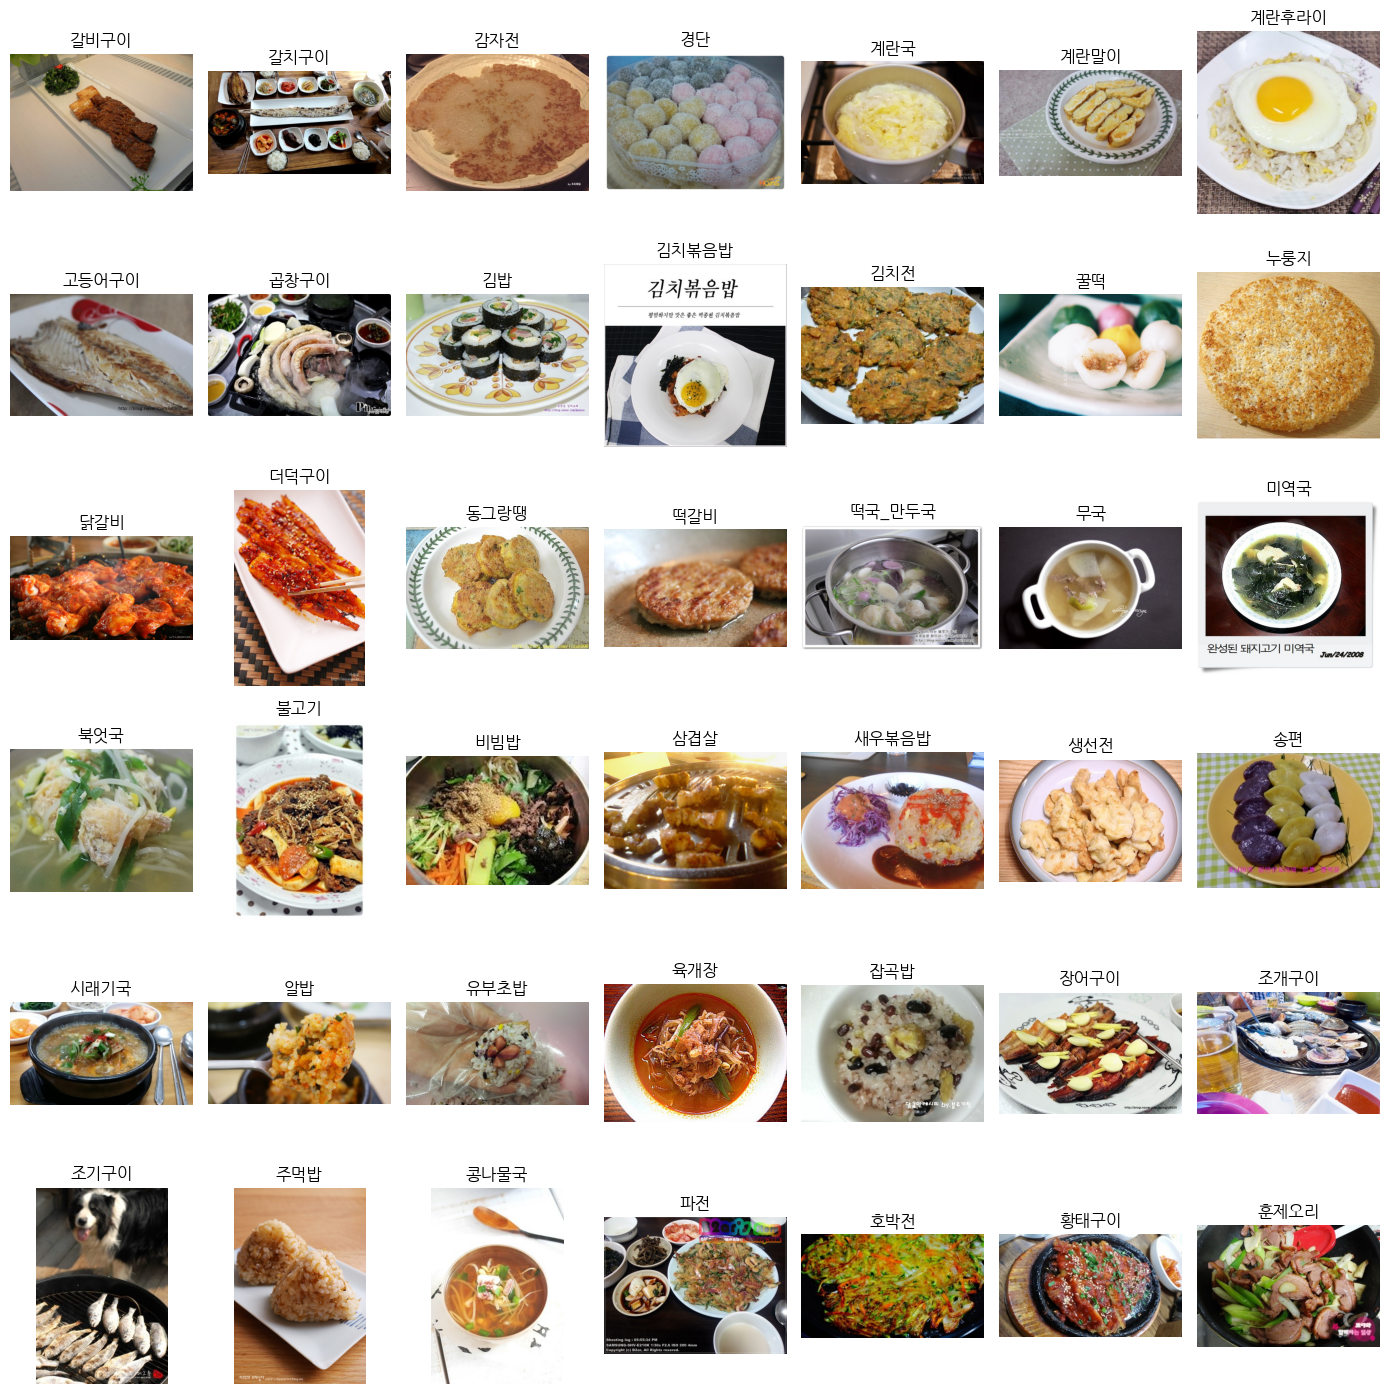

In [6]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import koreanize_matplotlib

class_names = ['갈비구이','갈치구이','감자전','경단','계란국','계란말이','계란후라이','고등어구이','곱창구이','김밥','김치볶음밥',
              '김치전', '꿀떡','누룽지','닭갈비','더덕구이','동그랑땡','떡갈비','떡국_만두국','무국','미역국','북엇국','불고기','비빔밥',
              '삼겹살','새우볶음밥','생선전','송편','시래기국','알밥','유부초밥','육개장','잡곡밥','장어구이','조개구이','조기구이','주먹밥',
              '콩나물국','파전','호박전','황태구이','훈제오리']
# 이미지가 있는 폴더 경로 설정
root_dir = '/content/drive/MyDrive/food/train/'

# 그리드 형태로 이미지 시각화
fig, axes = plt.subplots(6, 7, figsize=(14, 14))

for i, class_name in enumerate(class_names):
    folder_path = os.path.join(root_dir, class_name)
    images = os.listdir(folder_path)

    # 랜덤하게 이미지 선택
    random_image = random.choice(images)

    # 이미지를 시각화
    row = i // 7
    col = i % 7
    img = mpimg.imread(os.path.join(folder_path, random_image))
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_names[i])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

#데이터 전처리

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display
#from pytorchtools import EarlyStopping


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  2.1.0+cu121  Device :  cuda


In [8]:
#3. 하이퍼 파라미터
BATCH_SIZE =  64 #한 배치당 64개 이미지데이터
EPOCHS = 50# 전체 데이터 셋을 50번 반복

In [9]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

train_data_dir='/content/drive/MyDrive/food/train'
# Create the ImageFolder dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset = ImageFolder(root=train_data_dir, transform=transform)

# Define the sizes for the training and validation sets training and validation sets 의 size 정의
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining for validation

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [10]:
test_data_dir = '/content/drive/MyDrive/food/val'
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size used in training
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize using the same mean and standard deviation as training
])
test_dataset = ImageFolder(root=test_data_dir, transform=transform_test)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

#모델

In [11]:
# 모델
# pretrained

#데이터가 28*28로 단순하다 생각해서 일단 18로 진행
classes=['갈비구이','갈치구이','감자전','경단','계란국','계란말이','계란후라이','고등어구이','곱창구이','김밥','김치볶음밥',
              '김치전', '꿀떡','누룽지','닭갈비','더덕구이','동그랑땡','떡갈비','떡국_만두국','무국','미역국','북엇국','불고기','비빔밥',
              '삼겹살','새우볶음밥','생선전','송편','시래기국','알밥','유부초밥','육개장','잡곡밥','장어국이','조개구이','조기구이','주먹밥',
              '콩나물국','파전','호박전','황태구이','훈제오리']

def model_initialize():
    model = models.resnet18(pretrained=False)
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    # 1000 -> 10 로 fc를 수정. class가 10개니까
    model.fc = nn.Sequential(nn.Linear(num_ftrs, len(classes)),
                            )

    model = model.cuda()
    return model
model=model_initialize()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy

In [14]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    misclassified_images = []
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
                        # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy,misclassified_images

In [15]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    misclassified_images = []
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
                        # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy,misclassified_images

In [16]:
import os
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Define the directory where you want to save the model checkpoints
checkpoint_dir = '/content/drive/MyDrive/food/checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the interval for saving checkpoints (every 10 epochs)
checkpoint_interval = 10

# Initialize a dictionary to store checkpoint data
checkpoint_data = {
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'valid_losses': valid_losses,
    'valid_accuracies': valid_accuracies
}

for Epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer, log_interval=31)
    valid_loss, valid_accuracy, _ = evaluate(model, validation_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    scheduler.step()

    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".format(Epoch, train_loss, train_accuracy, valid_loss, valid_accuracy))


    # Save the model checkpoint every 10 epochs
    if Epoch % checkpoint_interval == 0:
        # Define the filename for the checkpoint
        checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{Epoch}.pt')

        # Save the checkpoint
        torch.save(checkpoint_data, checkpoint_filename)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:1]	 Train Loss:0.0464	 Train Acc:18.56 %  | 	Valid Loss:0.0442 	Valid Acc: 21.77 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:2]	 Train Loss:0.0384	 Train Acc:29.20 %  | 	Valid Loss:0.0419 	Valid Acc: 27.68 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:3]	 Train Loss:0.0331	 Train Acc:37.59 %  | 	Valid Loss:0.0415 	Valid Acc: 28.66 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:4]	 Train Loss:0.0291	 Train Acc:44.11 %  | 	Valid Loss:0.0334 	Valid Acc: 37.13 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:5]	 Train Loss:0.0255	 Train Acc:50.31 %  | 	Valid Loss:0.0297 	Valid Acc: 45.11 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:6]	 Train Loss:0.0225	 Train Acc:55.24 %  | 	Valid Loss:0.0271 	Valid Acc: 47.43 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:7]	 Train Loss:0.0198	 Train Acc:60.54 %  | 	Valid Loss:0.0251 	Valid Acc: 52.30 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:8]	 Train Loss:0.0173	 Train Acc:65.32 %  | 	Valid Loss:0.0268 	Valid Acc: 51.15 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:9]	 Train Loss:0.0149	 Train Acc:69.70 %  | 	Valid Loss:0.0230 	Valid Acc: 57.18 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:10]	 Train Loss:0.0126	 Train Acc:73.77 %  | 	Valid Loss:0.0230 	Valid Acc: 59.34 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:11]	 Train Loss:0.0100	 Train Acc:79.40 %  | 	Valid Loss:0.0231 	Valid Acc: 59.96 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:12]	 Train Loss:0.0076	 Train Acc:84.32 %  | 	Valid Loss:0.0266 	Valid Acc: 56.62 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:13]	 Train Loss:0.0056	 Train Acc:88.36 %  | 	Valid Loss:0.0259 	Valid Acc: 60.43 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:14]	 Train Loss:0.0041	 Train Acc:91.41 %  | 	Valid Loss:0.0332 	Valid Acc: 56.20 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:15]	 Train Loss:0.0035	 Train Acc:92.83 %  | 	Valid Loss:0.0339 	Valid Acc: 56.17 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:16]	 Train Loss:0.0025	 Train Acc:95.14 %  | 	Valid Loss:0.0312 	Valid Acc: 59.12 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:17]	 Train Loss:0.0022	 Train Acc:95.65 %  | 	Valid Loss:0.0352 	Valid Acc: 56.68 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:18]	 Train Loss:0.0018	 Train Acc:96.31 %  | 	Valid Loss:0.0356 	Valid Acc: 57.98 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:19]	 Train Loss:0.0022	 Train Acc:95.33 %  | 	Valid Loss:0.0342 	Valid Acc: 59.03 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:20]	 Train Loss:0.0016	 Train Acc:96.86 %  | 	Valid Loss:0.0327 	Valid Acc: 61.62 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:21]	 Train Loss:0.0004	 Train Acc:99.44 %  | 	Valid Loss:0.0254 	Valid Acc: 68.03 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:22]	 Train Loss:0.0001	 Train Acc:99.87 %  | 	Valid Loss:0.0261 	Valid Acc: 67.82 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:23]	 Train Loss:0.0002	 Train Acc:99.87 %  | 	Valid Loss:0.0259 	Valid Acc: 68.22 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:24]	 Train Loss:0.0001	 Train Acc:99.83 %  | 	Valid Loss:0.0263 	Valid Acc: 67.79 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:25]	 Train Loss:0.0001	 Train Acc:99.83 %  | 	Valid Loss:0.0293 	Valid Acc: 65.55 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:26]	 Train Loss:0.0006	 Train Acc:98.95 %  | 	Valid Loss:0.0367 	Valid Acc: 60.37 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:27]	 Train Loss:0.0009	 Train Acc:98.30 %  | 	Valid Loss:0.0308 	Valid Acc: 64.44 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:28]	 Train Loss:0.0002	 Train Acc:99.61 %  | 	Valid Loss:0.0298 	Valid Acc: 65.68 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:29]	 Train Loss:0.0002	 Train Acc:99.73 %  | 	Valid Loss:0.0299 	Valid Acc: 65.47 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:30]	 Train Loss:0.0004	 Train Acc:99.17 %  | 	Valid Loss:0.0368 	Valid Acc: 60.07 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:31]	 Train Loss:0.0006	 Train Acc:98.78 %  | 	Valid Loss:0.0345 	Valid Acc: 62.82 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:32]	 Train Loss:0.0003	 Train Acc:99.40 %  | 	Valid Loss:0.0331 	Valid Acc: 64.16 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:33]	 Train Loss:0.0003	 Train Acc:99.33 %  | 	Valid Loss:0.0342 	Valid Acc: 63.27 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:34]	 Train Loss:0.0003	 Train Acc:99.39 %  | 	Valid Loss:0.0376 	Valid Acc: 63.28 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:35]	 Train Loss:0.0004	 Train Acc:99.21 %  | 	Valid Loss:0.0350 	Valid Acc: 63.77 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:36]	 Train Loss:0.0003	 Train Acc:99.43 %  | 	Valid Loss:0.0361 	Valid Acc: 63.94 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:37]	 Train Loss:0.0004	 Train Acc:99.26 %  | 	Valid Loss:0.0353 	Valid Acc: 64.92 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:38]	 Train Loss:0.0003	 Train Acc:99.46 %  | 	Valid Loss:0.0375 	Valid Acc: 62.54 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:39]	 Train Loss:0.0004	 Train Acc:99.26 %  | 	Valid Loss:0.0388 	Valid Acc: 62.90 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:40]	 Train Loss:0.0003	 Train Acc:99.35 %  | 	Valid Loss:0.0371 	Valid Acc: 62.91 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:41]	 Train Loss:0.0001	 Train Acc:99.78 %  | 	Valid Loss:0.0322 	Valid Acc: 66.66 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:42]	 Train Loss:0.0000	 Train Acc:99.90 %  | 	Valid Loss:0.0318 	Valid Acc: 66.88 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:43]	 Train Loss:0.0000	 Train Acc:99.91 %  | 	Valid Loss:0.0324 	Valid Acc: 67.15 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:44]	 Train Loss:0.0000	 Train Acc:99.93 %  | 	Valid Loss:0.0322 	Valid Acc: 67.18 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:45]	 Train Loss:0.0000	 Train Acc:99.90 %  | 	Valid Loss:0.0324 	Valid Acc: 66.38 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:46]	 Train Loss:0.0000	 Train Acc:99.90 %  | 	Valid Loss:0.0343 	Valid Acc: 64.85 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:47]	 Train Loss:0.0001	 Train Acc:99.70 %  | 	Valid Loss:0.0351 	Valid Acc: 64.98 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:48]	 Train Loss:0.0001	 Train Acc:99.78 %  | 	Valid Loss:0.0338 	Valid Acc: 66.22 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:49]	 Train Loss:0.0001	 Train Acc:99.84 %  | 	Valid Loss:0.0346 	Valid Acc: 65.49 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



[EPOCH:50]	 Train Loss:0.0001	 Train Acc:99.87 %  | 	Valid Loss:0.0353 	Valid Acc: 65.19 %



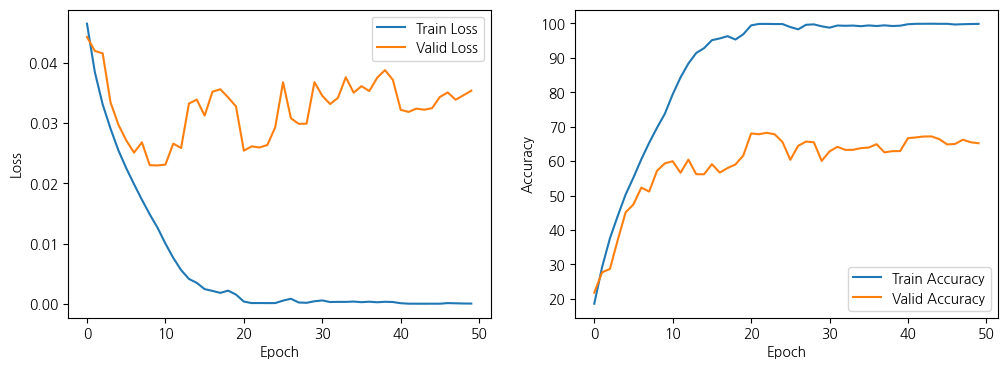

In [17]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Val Dataset으로 평가지표 확인

In [18]:
import os
from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from torch.backends import cudnn
cudnn.benchmark = True

In [19]:
# 채점시 사용되는 코드
# 본인의 코드에 사용해도 된다.
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [20]:
validate_epoch(model, test_loader,device="cuda")

measuring accuracy:   0%|          | 0/66 [00:00<?, ?it/s]

67.03192138671875